# Assignment 2

**Assignment 2: Sampling**

**Goal**: ​​Get familiar with sampling methods by implementing these methods and applying them to a given probability distribution.

In this assignment we are going to learn about sampling methods. The goal is to implement *Metropolis-Hastings** (MH) algorithm and **Simulated Annealing** (SA) algorithm and analyze their behavior. Importantly, we aim at noticing differences between these two methods.

Here, we are interested in ​**sampling**​ from a mixture of two Gaussians, namely:

$$
p(\mathbf{x}) = 0.25\cdot \mathcal{N}\left(\mu = \begin{bmatrix} 2 \\ 2 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 1 \end{bmatrix} \right) + 0.75\cdot \mathcal{N}\left(\mu = \begin{bmatrix} -3 \\ -3 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$

In this assignemnt, you are asked to implement:
1. The Metropolis-Hastings (MH) algorithm.
2. The simulated annealing (SA) algorithm.

After implementing both methods, please run experiments and compare both methods. Please follow all instructions.

## 1. Understanding the probability distribution

Please run the code below and visualize the probability distribution. Please try to understand this distribution, what the modes are (you can do it by inspecting the plot). What are possible problems here?

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from numpy import random

EPS = 1.0e-7

In [ ]:
# PLEASE DO NOT REMOVE!
# The definition of the probability distribution.
mv1 = multivariate_normal(mean=[2.0, 2.0], cov=[[1.0, 0.5], [0.5, 1.0]])
mv2 = multivariate_normal(mean=[-3.0, -3.0], cov=[[1.0, 0.0], [0.0, 1.0]])


def prob(x):
    return 0.25 * mv1.pdf(x) + 0.75 * mv2.pdf(x)

In [ ]:
# PLEASE DO NOT REMOVE!
# Calculating the probability distribution.
def calculate_p(x1, x2):
    p_x = []
    for i in range(len(x1)):
        for j in range(len(x2)):
            p_x.append(prob(np.asarray([[x1[i], x2[j]]])))

    return np.asarray(p_x).reshape(len(x1), len(x2))

In [ ]:
# PLEASE DO NOT REMOVE!
# Define coordinates
x1 = np.linspace(-10.0, 10.0, 400)
x2 = np.linspace(-10.0, 10.0, 400)

# Calculate the objective
p_x = calculate_p(x1, x2).reshape(len(x1), len(x2))

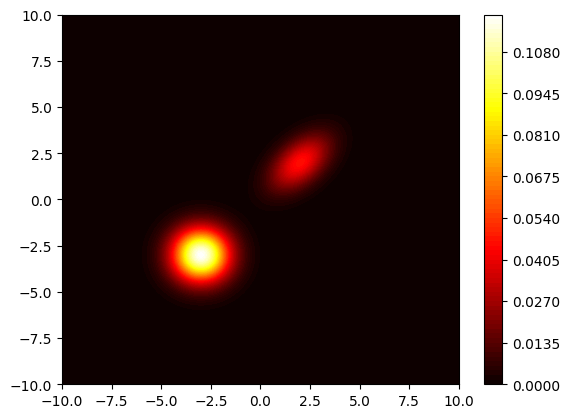

In [ ]:
# PLEASE DO NOT REMOVE!
# Plot the objective
plt.contourf(x1, x2, p_x, 100, cmap="hot")
plt.colorbar()

**Question 1 (0-0.5pt):** How many modes do we have and what are they? What is the most probable point?

**Answer:** There are 2 modes in the distribution which are (2,2) and (-3,-3). The most significant point is (-3,-3).

## 2. The Metropolis-Hastings algorithm

First, you are asked to implement the Metropolis-Hastings (MH) algorithm. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

NOTE: To implement the MH algorithm, you need to specify the proposal distribution.

**Question 2 (0-0.5pt):** What is the proposal distribution, $q(\mathbf{x}_{new} | \mathbf{x}_{old})$, in your case?

**Answer:**
My proposal distribution is the multivariance normal distrubution centered by the old point and the covariance is an indentity matrix times the given scalar.

**Question 3 (0-0.5pt):** Is your proposal a proper proposal distribution? (That is, it must fulfill irreducibility and aperiodicity, see Andrieu et al., "An Introduction to MCMC for Machine Learning".)

**Answer:**
The opted proposal would satisfy both conditions because the probability of visiting the next point always returns positive value and the chance of visiting the forward or backward point are the same with some probability; thus, it allow a fair exploration in the searching phase and stimulate the model to identify the global minimum.

In [ ]:
# =========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# =========
# Implement the Metropolis Hastings (MH) algorithm.
# It might be you use another arguments beside standard deviation (std).
# Please add them then.


class MetropolisHastings(object):
    def __init__(self, x, prob, std=0.1):
        self.prob = prob
        self.std = std
        self.x_old = x

    def proposal(self, x):
        # The new point is randomly sampled from
        # the mltivariant normal distribution centered by the current and covariance is std**2
        x_new = multivariate_normal(mean=x[-1], cov=self.std**2).rvs()
        return x_new

    def q_function(self,x_new, x_old):
        # return the propossal distribution the new point given the old point
        return multivariate_normal.pdf(x_new, mean = x_old, cov = self.std**2)


    def evaluate(self, x_new, x_old):
        # the likelihood of the proposal point
        prop_likelihood = self.prob(x_new) * self.q_function(x_old[-1],x_new)
        # the likelihood of the current point
        curr_likelihood = self.prob(x_old[-1]) * self.q_function(x_new, x_old[-1])
        # the acceptance probability
        A = prop_likelihood/curr_likelihood
        # return the minimum between A and 1.0
        return np.minimum(1.0, A)

    def select(self, x_new, A):
        # sample a random point from the uniform distribution between 0 and 1
        u = np.random.uniform(0,1)
        # if the acceptance probability is larger than u
        if A > u:
            # return the new point 
            return np.array([x_new])
        # Otherwise, return the current point
        return self.x_old
        

    def step(self):
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old)
        # 3. Select
        x_new = self.select(x_prop, A)
        # Set the current point to the point just selected
        self.x_old = x_new 
        return x_new

In [ ]:
# PLEASE DO NOT REMOVE!
# An auxiliary function for plotting.
def plot_sampling_process(ax, sampler, title):
    # Plot the objective function
    ax.contourf(x1, x2, p_x / p_x.sum(), 100, cmap="hot")

    # Init the solution
    x_samp = sampler.x_old
    # Run the optimization algorithm
    count = 0  # we calculate how many of new candidates were accepted
    for i in range(num_epochs):
        x = sampler.step()

        if (x == x_samp[-1]).all():
            pass
        else:
            count = count + 1
            x_samp = np.concatenate((x_samp,x), 0) 

    ax.scatter(x_samp[:, 0], x_samp[:, 1], marker="+")
    # We add AR (Acceptance Rate) to the title.
    ax.set_title(title + " AR={:.2f}".format(count / num_epochs))

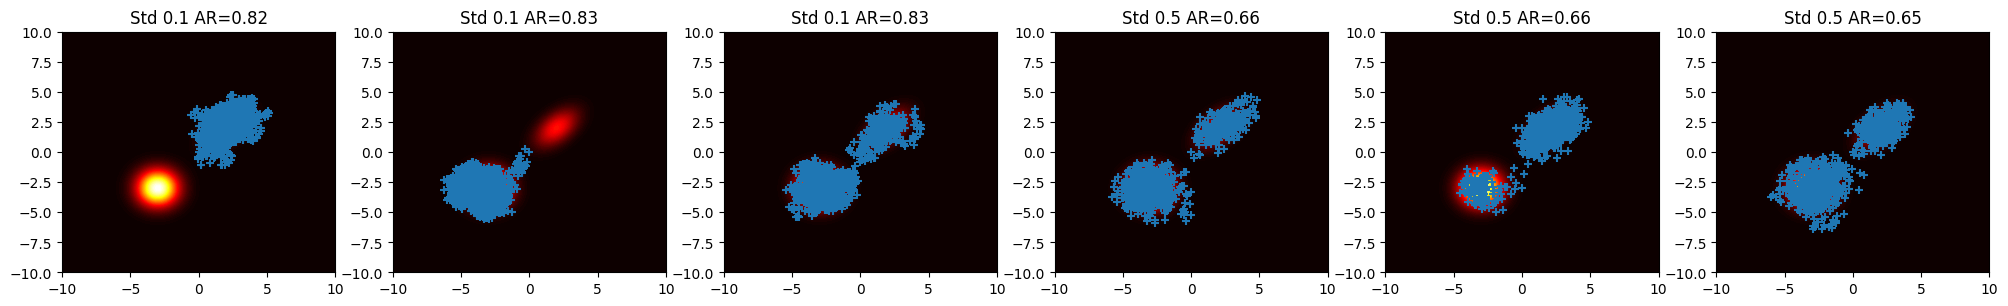

In [ ]:
# PLEASE DO NOT REMOVE!
# Running the MH algorithm with different step sizes
num_epochs = 1500  # the number of epochs
stds = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5]  # we repeat experiments 3 times per std
## If you add any other hyperparameters, please include them during init!
## However, please do not include them in the for-loop. It should stay for stds only.

# plotting the convergence of the MH
fig_mh, axs = plt.subplots(1, len(stds), figsize=(20, 3))
fig_mh.tight_layout()

x_init = np.asarray([[0.0, 0.0]])

for i in range(len(stds)):
    # take the std
    std = stds[i]
    # init the MH
    mh = MetropolisHastings(x=x_init, prob=prob, std=std)
    # plot the convergence
    plot_sampling_process(axs[i], sampler=mh, title=f"Std {std}")

**Question 4 (0-0.5)**: Please comment on the behavior of the MH for different values of the standard deviation. Is it always possible to sample from both modes theoretically? What did you observe in practice on plots? 

**Answer**: In the result, it is observed that with the same standard deviation 0.1, it can be possibly sampled from either one of the modes, but the less considerable would return a faster convergence than the more significant mode. Apparent, it can be sampled from both models with standard deviation 0.1. With respect to the standard deviation 0.5, all rounds return the samples which were all drawn from both modes with the stable accaeptable rate. 

**Question 5 (0-0.5)**: Please comment on the acceptance ratio (AR) for std=0.1 and std=0.5. How can you explain the difference?

**Answer**: The searching of Metropolis-Hasting with the set standard deviation equals to 0.5 would return a higher chance of sampling points from both modes than that of standard deviation 0.1. Besides, the acceptance rate of the samples with standard deviation 0.5 is fairly lower than that of the standard deviation 0.1. One feasible reason behind the phenomenon is the higher standard deviation allow a larger searching step, then it would search the local (or global) optimum faster or we can say it converges faster. Thus, it takes less iterations for the searching phases.

## 3. The simulated annealing (SA) sampling

In the second part of this assignment, you are asked to implement the Simulated Annealing (SA) algorithm with cooling scheme as dicussed during the lecture.

**Question 6 (0-0.5pt)**: Please explain what is the difference between MH and SA?

**Answer**: Simulated Annealing (SA) is quite similar to the Metropolis-Hasting approach with accompanied to the simulated annealing of metal. Now, in the expected value of proposal points or old points, the probability of such poitns would be powered to 1 over the temperature $ \mathbf{T}_{t}$. Furthermore, the next temperature would follow the formula $ \mathbf{T}_{t}= (C*ln(t+\mathbf{T}_{0}))^{-1}$.

In [ ]:
# =========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# NOTE: The cooling scheme must be properly implemented!
# =========
# Implement the Simulated Annealing (SA) algorithm.
# It is equivalent to implementing the step function.
class SimulatedAnnealing(object):
    def __init__(self, x, prob, std=0.1, T0=1.0, C=1.0):
        self.prob = prob
        self.std = std
        self.x_old = x
        self.T0 = T0
        self.C = C
        self.t = 0  # we init the step number to 0; we need it for cooling scheme

    def proposal(self, x):
        # PLEASE FILL IN
        x_new = multivariate_normal(mean=x[-1], cov = self.std**2).rvs()
        return x_new

    def q_function(self,x_new, x_old):
        # return the propossal distribution the new point given the old point
        return multivariate_normal.pdf(x_new, mean = x_old, cov = self.std**2)

    def evaluate(self, x_new, x_old, T):
        # the likelihood of the proposal point
        prop_likelihood = (self.prob(x_new)**(1/T)) * self.q_function(x_old[-1],x_new) # the probability of a point now is power to (1/T)
        # the likelihood of the current point
        curr_likelihood = (self.prob(x_old[-1])**(1/T)) * self.q_function(x_new, x_old[-1])
        # the acceptance probability
        A = prop_likelihood/curr_likelihood
        # return the minimum between A and 1.0
        return np.minimum(1.0, A)
    
    def select(self, x_new, A):
        # sample a random point from the uniform distribution between 0 and 1
        u = np.random.uniform(0,1)
        # if the acceptance probability is larger than u
        if A > u:
            # return the new point 
            return np.array([x_new])
        # Otherwise, return the current point
        return self.x_old
        

    def step(self):
        # The temperature scheme (the cooling scheme)
        # Calculate the current temperature by the mentioned formula
        T = 1/(self.C*np.log(self.t+self.T0))
        # Increase the numebr of iterations by 1
        self.t = self.t + 1
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old, T)
        # 3. Select
        x_new = self.select(x_prop, A)
        # Set the current point to the point just selected
        self.x_old = x_new
        return x_new

**Question 7 (0-0.5pt)**: Why is SA sometimes more preferrable than MH? Which of these two methods would you use for optimization (not sampling)?

**Answer**: The crucial point is that SA first allow to search the state space in the broader range when compared to MH. Then, when all states are sufficiently explored, the temperatured is cooled down and now the searching will prirotize the exploitation in a small but important zone by descreasing the temperature. In the meanwhile, MH possibly biased to the local optimum and ignore the farer gloabl optimum. 

<ipython-input-15-8c726b9b742d>:47: RuntimeWarning: divide by zero encountered in double_scalars
  T = 1/(self.C*np.log(self.t+self.T0))


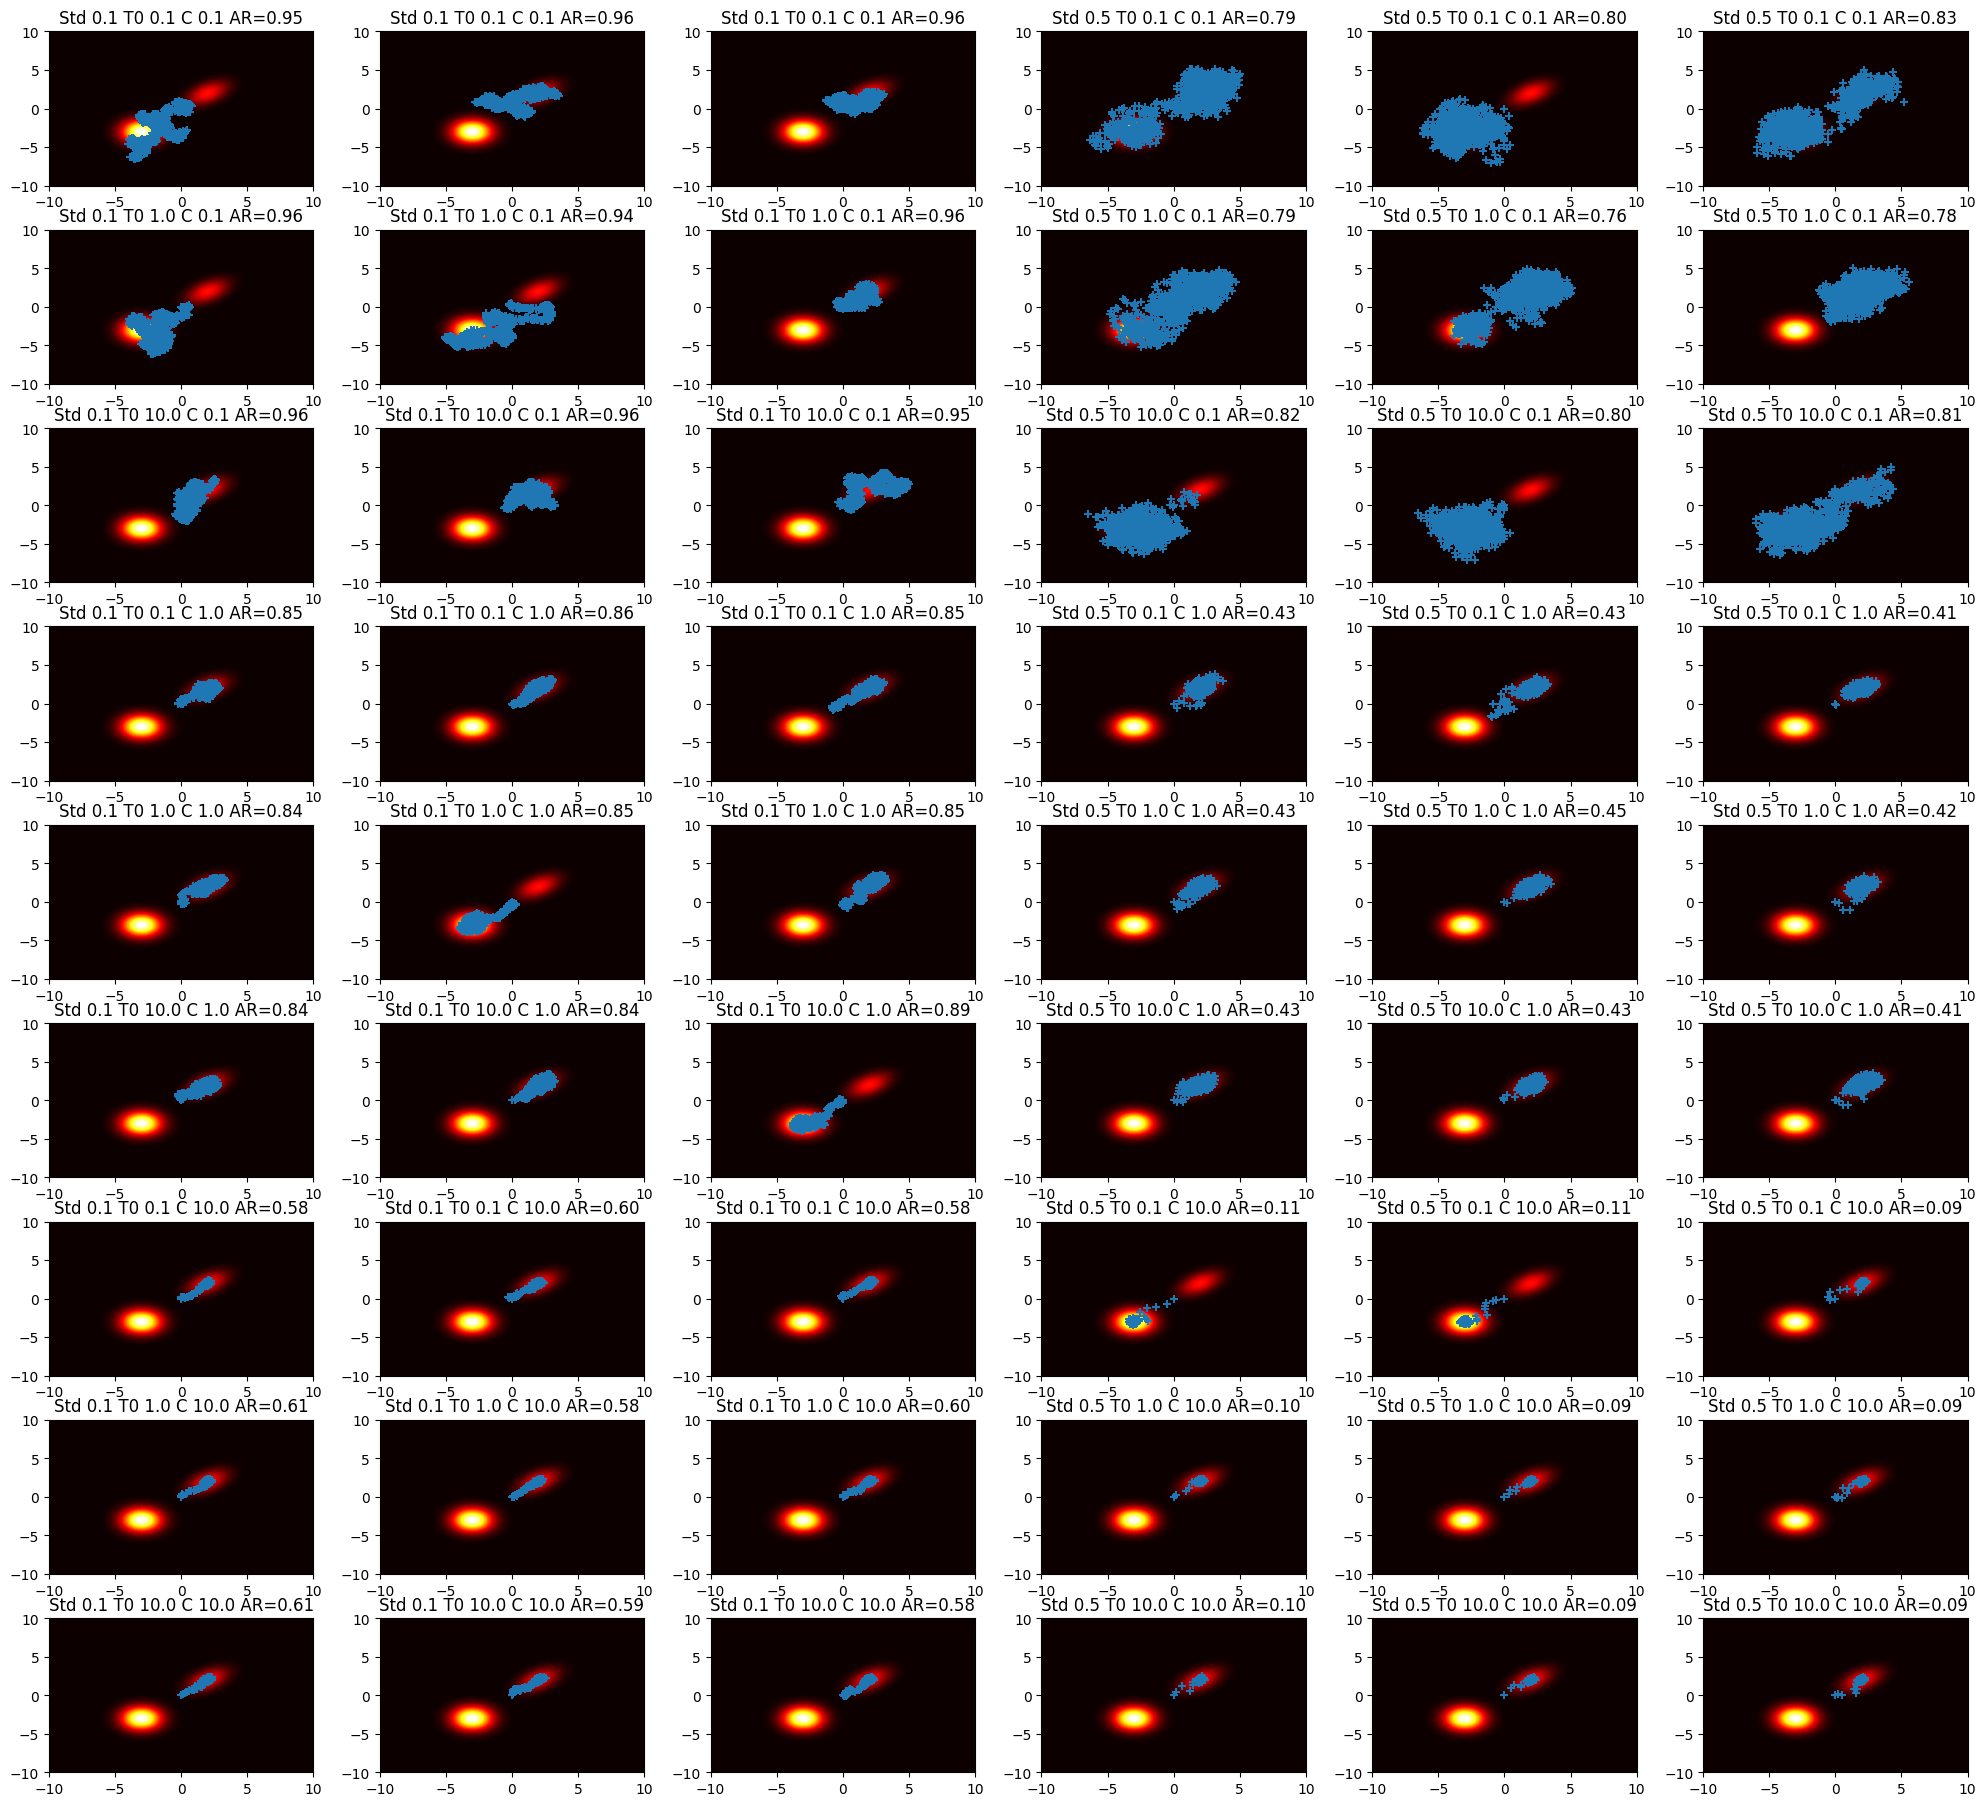

In [ ]:
# PLEASE DO NOT REMOVE!
# Running the SA algorithm with different step sizes
num_epochs = 1500  # the number of epochs
stds_sa = [
    0.1,
    0.1,
    0.1,
    0.5,
    0.5,
    0.5,
]  # values of std; notice we repeat them due to randomness
T0s = [0.1, 1.0, 10.0]  # values of T0
Cs = [0.1, 1.0, 10.0]  # values of C

# plotting the convergence of the MH
fig_sa, axs = plt.subplots(len(Cs) * len(T0s), len(stds_sa), figsize=(20, 18))
fig_sa.tight_layout()

# Always start with the same point
x_init = np.asarray([[0.0, 0.0]])

# START SA
for i in range(len(Cs)):
    # Take a value for C
    C = Cs[i]
    for k in range(len(T0s)):
        # Take a value for the init temperature T0
        T0 = T0s[k]
        for j in range(len(stds_sa)):
            # take the std
            std = stds_sa[j]
            # init the SA
            sa = SimulatedAnnealing(x=x_init, prob=prob, std=std, T0=T0, C=C)
            # plot the sampling process
            plot_sampling_process(
                axs[len(T0s) * i + k, j],
                sampler=sa,
                title="Std " + str(sa.std) + " T0 " + str(T0) + " C " + str(C),
            )

**Question 8 (0-0.5pt)** How does the standard deviation influence the SA?

**Answer:** Similar to MH, it allows the searching excuted in a broader space when the standard deviation is set largely. Specifically, in the first 3 rows of the outcomes, every row is set with the corresponding initial tempature and C = 0.1, it is clearly seen that SA with standard deviation 0.5 returned the samples drawn mostly from 2 modes while that of the standard deviation 0.1 sampled points belonged to either one of the modes.

**Question 9 (0-0.5pt)** How does the initial temperature, $T_0$, influence the SA?

**Answer:** From my perspective, the initial temperature has a fairly minor influence in the searching space. I does decrease the acceptance rate but only of 1 or 2 percent. Besides, within 6 searching iterations, it did not indicate the preference between exploitation and exploration. Definitly, the judgement would be more objective if we generate more searching roumds. 

**Question 10 (0-0.5pt)** How does the constant $C$ influence the SA?

**Answer:** Contrast to the initial temperature, the hyperparameter C has an enormous influence on the searching phase. It is obviously witnessed between the first 3 rows and the last 3 ones. We possibly make a judgement that when the C is set larger, the acceptance rate is corresponding dropped. In the searching space, when C is 10, there are not as many as points are sampled when compared to C as 0.1. Thus, it results in more priority put in exploitation over exploration and truly all most samples are drawn from the less considerable modes when C is 10 (depicted in the last 3 rows). 

**Question 11 (0-0.5pt)** Which setting (i.e., std, $T_0$, $C$) did perform the best in terms of sampling?

**Answer:** Personally, the hyperparameter C has the most superior performance in the sampling. With the view from the top to bottom in the graph, we saw that the number of points were drawn from the given distribution declined siginicantly, and more biased to the less remarkable modes. Besides, it directly decreased the acceptance rate by a great amount.

**Question 12 (0-0.5pt)** How do different values of the hyperparameters (i.e., std, $T_0$, $C$) influence the acceptance ratio (AR)? Why?

**Answer:** First, standard deviation (std) has a negative relation to the acceptance ratio (RA). Evidence is that the AR of the first 3 columns is always higher than these of the last 3 columns. The explantion can be provided previously is that the high std permit a larger step for the next point, then the next point would converge the optimum faster. Consequently, the acceptance rate is lower.

Second, the intial temperature have a quite positive relation with AR. Since, when the initial temperature $T_0$ is increased, the temperture at each round $\mathbf{T}_{t}$ would be decreased or $1/{\mathbf{T}_{t}}$ increases. Thus, the acceptance probability grows or the acceptance rate consequently grows. However, as mentioned before, the initial temperature have a small effect in the searching process and possible controll the exploration and exploitation trade-off in the beginning steps. 

Ultimately, the hyperparameter C has a significantly negative effect in AR. In the graph, when C is 0.1, the AR fluctuated arounf 0.76 and 0.95. Howeve, when it is larger, specifically 10, the AR drop to even 0.09. The feasible reason could be the increase in C leads to the decrease in the acceptable probability  A. Then, the chance that the value of A is lower than u is higher, thus it located in the stationary distribution. 

## 4. Final remarks: MH vs. SA

Eventually, please answer the following last questions that will allow you to conclude the assignment and draw conclusions.

**Question 13 (0-0.5-1pt)**: Which of the two algorithms did perform better? Why?

**Answer**: I would judge their performance based on their AR and average sampled distribution. I would opt for the SA since with the approriate set of hyperparameter, it is flexible to controll the trade-off between the exploration and exploitation. Besides, the converge occurs faster than that of MH. However, the average performances between 2 algorithm are comparable. 

**Question 14 (0-0.5-1pt)**: Which of the two algorithms is easier to use? Why?

**Answer**: Definitely, the MH is friendlier to non-accademic pepople. Since it has less hyperparameters, it takes less experiments to explore the best configuration. Besides, the SA requires math foundation to work in the formula of temperature. 